In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train_csv = pd.read_csv("train_old.csv")
test_csv = pd.read_csv("test_old.csv")

In [3]:
y_temp = train_csv["target"]
x_temp = train_csv.drop(["id", "target"], axis = 1)

In [4]:
#Pearson correlation coefficient
correlation = train_csv.corr()
col_corr = correlation.nlargest(11 ,'target')['target'].index[1:]
print('Best 10 feature by correlation:',col_corr)

Best 10 feature by correlation: Index(['33', '65', '24', '183', '199', '201', '30', '289', '114', '164'], dtype='object')


In [5]:
#Recursive feature elimination (RFE)
estimator = LogisticRegression()     
rfe = RFE(estimator=estimator, n_features_to_select=10, step=1)
rfe = rfe.fit(x_temp, y_temp)
col_rfe = x_temp.columns[rfe.support_]
print('Best 10 feature by rfe:',col_rfe)

Best 10 feature by rfe: Index(['33', '65', '73', '80', '91', '108', '189', '194', '199', '217'], dtype='object')


In [6]:
#Recursive feature elimination with cross validation
estimator = LogisticRegression()   
rfecv = RFECV(estimator=estimator, step=1, cv=5,scoring='accuracy')  
rfecv = rfecv.fit(x_temp, y_temp)

col_rfecv = x_temp.columns[rfecv.support_]
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', col_rfecv)

Optimal number of features : 6
Best features : Index(['33', '65', '73', '91', '199', '217'], dtype='object')


In [7]:
col = col_rfecv
x = train_csv[col].values
test = test_csv[col].values
y = train_csv['target']

In [8]:
scaler = RobustScaler()
x_final = scaler.fit_transform(x)
test_final = scaler.fit_transform(test)
x_final = pd.DataFrame(x_final)
test_final = pd.DataFrame(test_final)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_final, y, test_size=0.15, random_state = 42) 

In [10]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [11]:
estimator_KNN = KNeighborsClassifier()
param_grid = {
    'n_neighbors':list(range(1, 21)),
    'metric':['euclidean', 'manhattan', 'minkowski'],
    'weights':['uniform', 'distance']}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator_KNN, param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search=grid.fit(X_train, y_train)
print("Best Parameters: " + str(grid_search.best_params_))
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_weights = grid_search.best_params_['weights']

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
Accuracy for our training dataset with tuning is : 77.43%


In [12]:
KNN = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
KNN.fit(X_train, y_train)
y_predict = KNN.predict(X_test)
print("-------------------------------------")
print("Results of KNeighborsClassifier:")
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))
accuracy_knn = accuracy_score(y_test,  y_predict)
print('Prediction accuracy',accuracy_knn*100,'%')
print('Train score' , KNN.score(X_train, y_train))
print("-------------------------------------")

-------------------------------------
Results of KNeighborsClassifier:
[[11  0]
 [ 2 25]]
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        11
         1.0       1.00      0.93      0.96        27

    accuracy                           0.95        38
   macro avg       0.92      0.96      0.94        38
weighted avg       0.96      0.95      0.95        38

Prediction accuracy 94.73684210526315 %
Train score 0.8113207547169812
-------------------------------------


Text(0.5, 1.0, 'Results of KNeighborsClassifier')

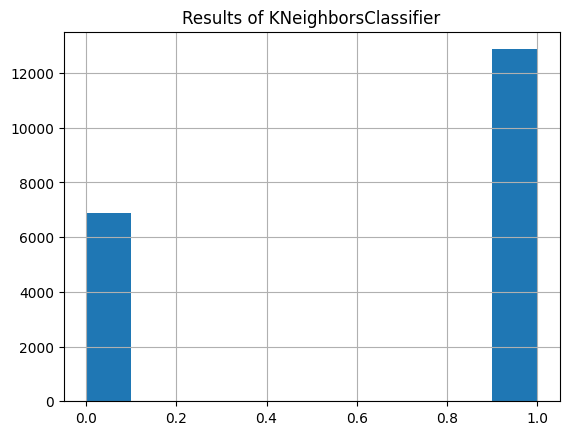

In [13]:
ypred_KNN = KNN.predict(test_final)
output_KNN = pd.DataFrame({'id':range(250, 20000),'target': ypred_KNN})
output_KNN.to_csv('submission_KNN.csv', index=False)
output_KNN['target'].hist().set_title("Results of KNeighborsClassifier")